In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm, uniform, lognorm

In [2]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

In [3]:
x_min, x_max = dat_adults['weight'].min(), dat_adults['weight'].max()

### How to determine a good prior for $\beta$?

In [4]:
n_pre_prior = 100

sample_alpha = norm.rvs(size=n_pre_prior, loc=170, scale=10)
sample_beta  = norm.rvs(size=n_pre_prior, loc=0, scale=10)

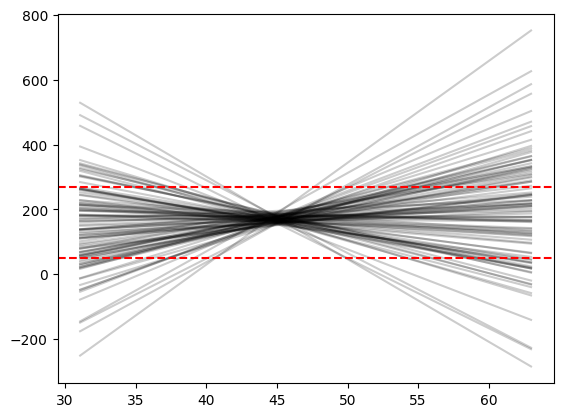

In [5]:
_ = plt.plot([x_min, x_max],
         [sample_alpha+sample_beta*(x_min-dat_adults['weight'].mean()),
          sample_alpha+sample_beta*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)
plt.axhline(50, linestyle='--', color='red')
plt.axhline(270, linestyle='--', color='red')

In [6]:
sample_alpha = norm.rvs(size=n_pre_prior, loc=170, scale=10)
sample_beta  = lognorm.rvs(size=n_pre_prior, s=0.25)

(array([ 4., 11., 28., 20., 16., 10.,  5.,  3.,  1.,  2.]),
 array([0.47885642, 0.64561174, 0.81236706, 0.97912238, 1.14587771,
        1.31263303, 1.47938835, 1.64614367, 1.81289899, 1.97965431,
        2.14640964]),
 <BarContainer object of 10 artists>)

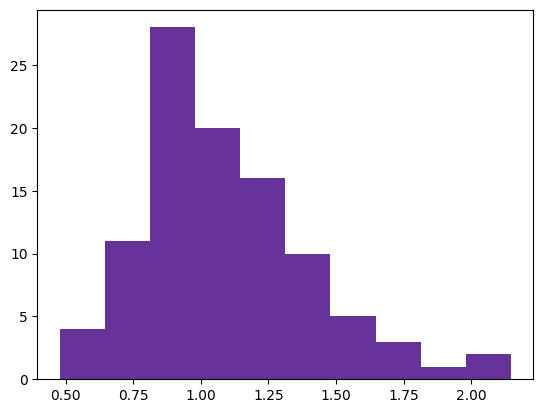

In [7]:
plt.hist(sample_beta, color='rebeccapurple')

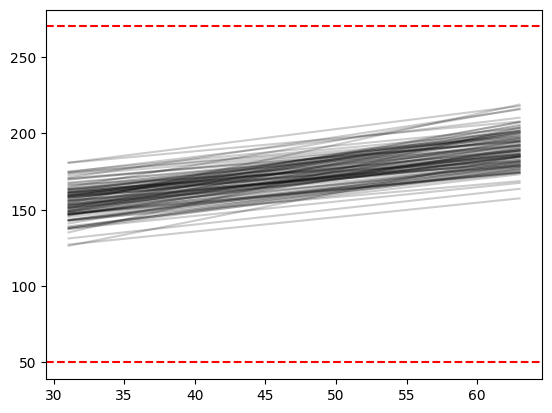

In [8]:
_ = plt.plot([x_min, x_max],
         [sample_alpha+sample_beta*(x_min-dat_adults['weight'].mean()),
          sample_alpha+sample_beta*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)
plt.axhline(50, linestyle='--', color='red')
plt.axhline(270, linestyle='--', color='red')

### Approximating the posterior

In [9]:
alpha_list = np.linspace(153.5, 155.5, 100)
beta_list  = np.linspace(0.5, 1, 100)
sigma_list = np.linspace(4, 6, 100)

alpha_grid, beta_grid, sigma_grid = np.meshgrid(alpha_list, beta_list, sigma_list)

In [10]:
like = []

for i in range(len(alpha_grid.ravel())):
    mu = alpha_grid.ravel()[i] + beta_grid.ravel()[i]*(dat_adults['weight']-dat_adults['weight'].mean())
    like.append(norm.logpdf(dat_adults['height']-mu, 0, sigma_grid.ravel()[i]).sum())
    
like = np.array(like).reshape(alpha_grid.shape)

In [11]:
post_prod = like + norm.logpdf(alpha_grid, 170, 10) + uniform.logpdf(sigma_grid, loc=0, scale=33) + lognorm.logpdf(beta_grid, s=1)

### Sampling from the posterior

In [12]:
n_sample = 10**4

candidates = pd.DataFrame(np.c_[alpha_grid.ravel(), beta_grid.ravel(), sigma_grid.ravel()], columns=['alpha', 'beta', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(post_prod - post_prod.max()).ravel(), k=n_sample)

sample_posterior = candidates.iloc[sample_ind]

<AxesSubplot:xlabel='alpha', ylabel='beta'>

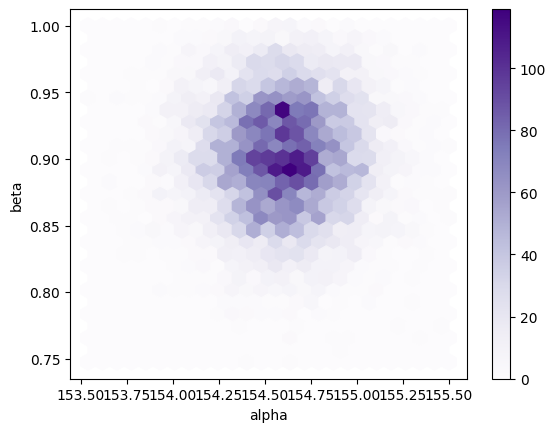

In [13]:
sample_posterior.plot.hexbin(x='alpha', y='beta', cmap='Purples', gridsize=25)

(array([  10.,   57.,  357.,  998., 2313., 2932., 1981., 1040.,  265.,
          47.]),
 array([153.54040404, 153.73636364, 153.93232323, 154.12828283,
        154.32424242, 154.52020202, 154.71616162, 154.91212121,
        155.10808081, 155.3040404 , 155.5       ]),
 <BarContainer object of 10 artists>)

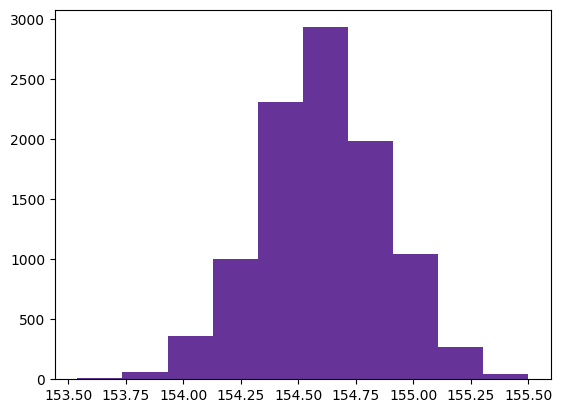

In [14]:
plt.hist(sample_posterior['alpha'], color='rebeccapurple')

(array([   9.,   32.,  213.,  654., 1326., 2166., 2310., 1881.,  993.,
         416.]),
 array([0.74747475, 0.77272727, 0.7979798 , 0.82323232, 0.84848485,
        0.87373737, 0.8989899 , 0.92424242, 0.94949495, 0.97474747,
        1.        ]),
 <BarContainer object of 10 artists>)

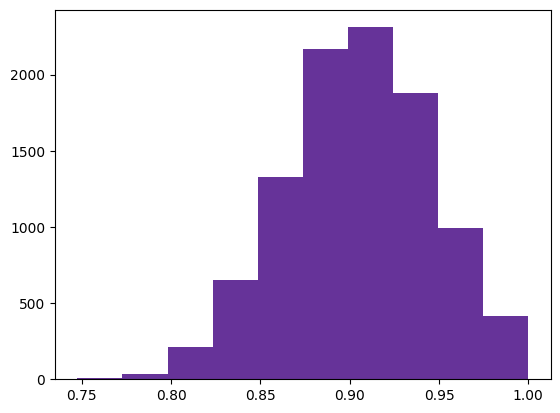

In [15]:
plt.hist(sample_posterior['beta'], color='rebeccapurple')

(array([  51.,  347., 1292., 2976., 2726., 1701.,  711.,  155.,   32.,
           9.]),
 array([4.48484848, 4.63232323, 4.77979798, 4.92727273, 5.07474747,
        5.22222222, 5.36969697, 5.51717172, 5.66464646, 5.81212121,
        5.95959596]),
 <BarContainer object of 10 artists>)

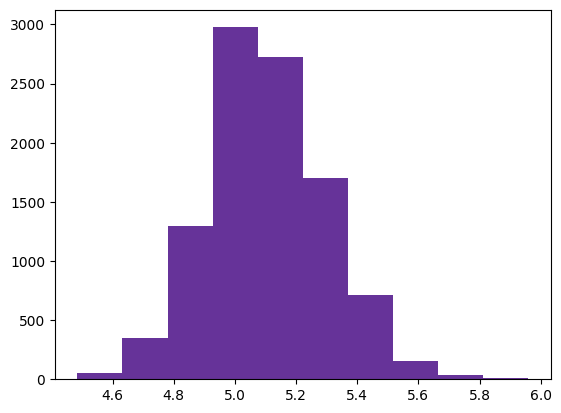

In [16]:
plt.hist(sample_posterior['sigma'], color='rebeccapurple')

In [17]:
sample_posterior.describe()

,alpha,beta,sigma
count,10000.000000,10000.000000,10000.000000
mean,154.605226,0.902307,5.103127
std,0.270290,0.040885,0.194163
min,153.540404,0.747475,4.484848
25%,154.429293,0.873737,4.969697
50%,154.611111,0.904040,5.090909
75%,154.792929,0.929293,5.232323
max,155.500000,1.000000,5.959596


### Model considering the MAPs for $\alpha$ and $\beta$

In [18]:
alpha_map = sample_posterior['alpha'].mode()
beta_map  = sample_posterior['beta'].mode()

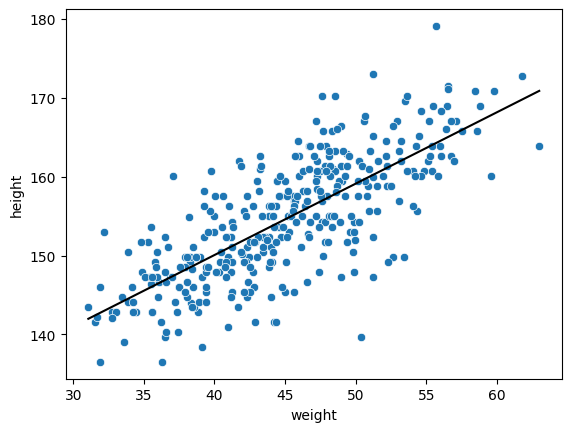

In [19]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k')

### Plotting all the sample of a posteriori models

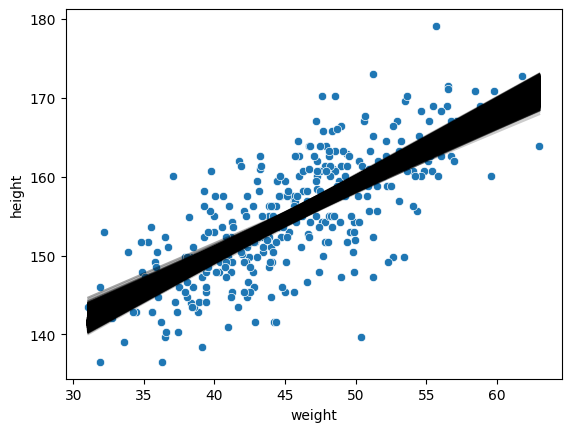

In [20]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
_ = plt.plot([x_min, x_max],
         [sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
          sample_posterior['alpha']+sample_posterior['beta']*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)

### How much is $\mu$ for a given weight?

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

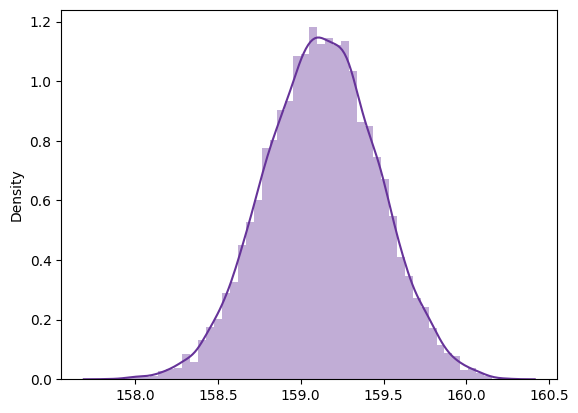

In [21]:
# weight=50
sns.distplot(sample_posterior['alpha']+sample_posterior['beta']*(50-dat_adults['weight'].mean()), color='rebeccapurple')

### Estimating confidence intervals

In [22]:
weight_seq = np.linspace(x_min, x_max)

In [23]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [24]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(sample_posterior['alpha']+sample_posterior['beta']*(weight_seq[i]-dat_adults['weight'].mean()),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [25]:
ConfidenceIntervals['weight'] = weight_seq

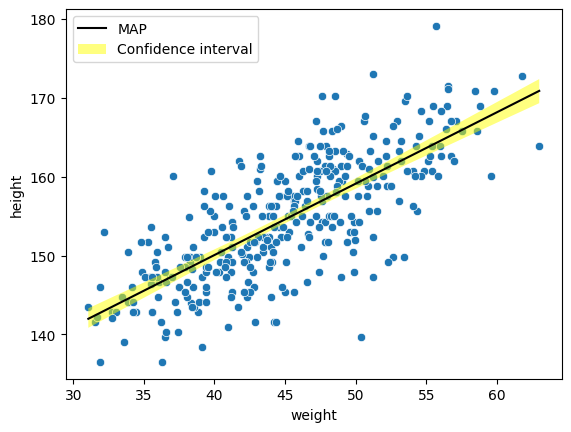

In [26]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k', label='MAP')
plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence interval')
plt.legend()

### Adding prediction intervals

### Predicting height for a given weight

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

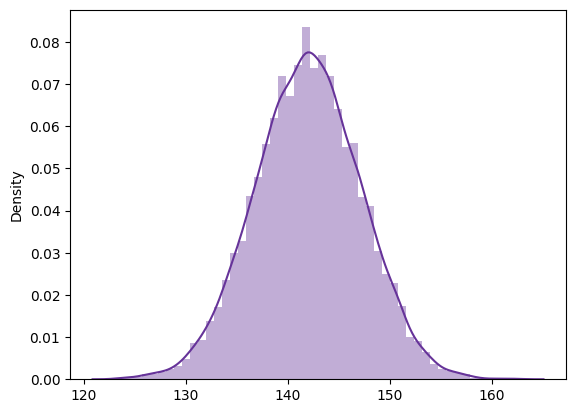

In [27]:
# weight=50
sns.distplot(
    norm.rvs(
        size=n_sample
        , loc=sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean())
        , scale=sample_posterior['sigma'])
    , color='rebeccapurple'
)

### Estimating prediction intervals

In [28]:
height_samp = norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [29]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(weight_seq[i]-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [30]:
PredictionIntervals['weight'] = weight_seq

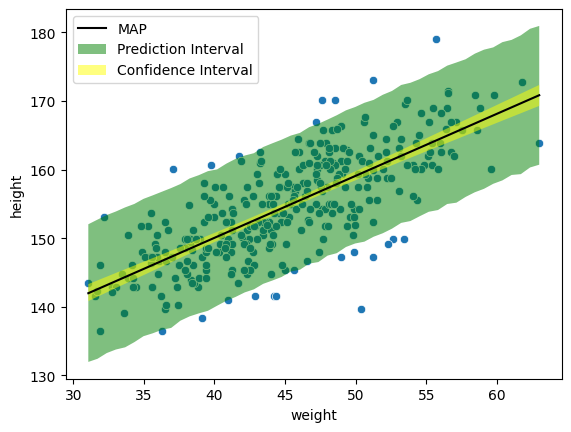

In [31]:
sns.scatterplot(data=dat_adults, x='weight', y='height')

plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()